# Train a deep convolutional SNN on the rawHD dataset

This notebook demonstrates training of a feed-forward convolutional SNN on the [raw Heidelberg Digits dataset](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/). Data is encoded using a trainable encoder layer.

In [1]:
# First, imports
import os
import sys
sys.path.append("../../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork
from stork.datasets import RawHeidelbergDigits, DatasetView
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, MaxPool1d
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer, DistInitializer
from stork.layers import ConvLayer


## Load RawHD dataset

In [2]:
# Data 
datadir = "/tungstenfs/scratch/gzenke/datasets/RawHeidelbergDigits"
cachedir = '/tungstenfs/scratch/gzenke/datasets/cache/'
standardize_inputs = False
validation_split = 0.9

nb_inputs = 40
duration = 0.4
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
nb_input_steps = 80
time_scale = 1.0


In [3]:
datagen_kwargs = dict(nb_steps=nb_input_steps,
                      time_step=10e-3,
                      standardize=standardize_inputs,
                    )

def read_filelist(filename):
    with open(filename) as f:
        content = f.readlines()
    # Remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    return content

train_dataset = RawHeidelbergDigits(datadir, 
                                    subset=read_filelist("%s/train_filenames.txt"%datadir), 
                                    cache_fname="%s/rawhd-std%i-cache-training.pkl.gz"%(cachedir, standardize_inputs), 
                                    **datagen_kwargs)

test_dataset = RawHeidelbergDigits(datadir, 
                                   subset=read_filelist("%s/test_filenames.txt"%datadir), 
                                   cache_fname="%s/rawhd-std%i-cache-test.pkl.gz"%(cachedir, standardize_inputs), 
                                   **datagen_kwargs)

if validation_split:
    mother_dataset=train_dataset
    elements = np.arange(len(mother_dataset))
    np.random.shuffle(elements)
    split = int(validation_split*len(mother_dataset))
    train_dataset = DatasetView(mother_dataset, elements[:split])
    valid_dataset = DatasetView(mother_dataset, elements[split:])

Found 10420 flac files ...
Selected 8156 flac files ...


Finished loading 8156 cached data ...
Found 10420 flac files ...
Selected 2264 flac files ...
Finished loading 2264 cached data ...


## Set up model

In [4]:
# Model Parameters
# # # # # # # # # # #

beta = 20

# Encoder Parameters
# # # # # # # # # # #

encoder_fanout = 10
encoder_gain = 1

# Hidden layer blocks
# # # # # # # # # # #

nb_hidden_blocks = 1
nb_classes = 20
nb_hidden_channels = encoder_fanout

kernel_size = 5        # Convolutional operation parameters
stride = 1
padding = 2

recurrent_kwargs = {'kernel_size': 5,
                    'stride': 1,
                    'padding': 2}

# Neuron Parameters
# # # # # # # # # # #

neuron_group = LIFGroup
tau_mem = 20e-3
tau_syn = 5e-3
tau_readout = 20e-3

# Training parameters
# # # # # # # # # # #

batch_size = 100
device = torch.device("cuda")
dtype = torch.float
lr = 5e-3
nb_epochs = 30

### Regularizer setup

In [5]:
PopUpperBoundL2Strength = 0.1
PopUpperBoundL2Threshold = 50    

PopUpperBoundL1Strength = 0.1   
PopUpperBoundL1Threshold = 20

NeuronLowerBoundL2Strength = 100
NeuronLowerBoundL2Threshold = 1e-3

NeuronUpperBoundL2Strength = 0.1
NeuronUpperBoundL2Threshold = 60

scale_act_reg = 1.0/(2*nb_hidden_blocks+1.0)

# population upper bound
PopUBL2 = stork.regularizers.UpperBoundL2(scale_act_reg * PopUpperBoundL2Strength,
                                          threshold=PopUpperBoundL2Threshold, 
                                          dims=(-2, -1))

# population upper bound
PopUBL1 = stork.regularizers.UpperBoundL1(scale_act_reg * PopUpperBoundL1Strength,
                                          threshold=PopUpperBoundL1Threshold, 
                                          dims=(-2, -1))

# Per-feature lower bound
NeuLBL2 = stork.regularizers.LowerBoundL2(scale_act_reg * NeuronLowerBoundL2Strength,
                                          threshold=NeuronLowerBoundL2Threshold,
                                          dims=(-1))                          

# Per-neuron upper bound
NeuUBL2 = stork.regularizers.UpperBoundL2(NeuronUpperBoundL2Strength,
                                          threshold=NeuronUpperBoundL2Threshold, 
                                          dims=False)

regs = [PopUBL2, PopUBL1, NeuLBL2, NeuUBL2]

### SuperSpike and loss function

In [6]:
act_fn = stork.activations.SuperSpike
act_fn.beta = beta

loss_stack = stork.loss_stacks.SumOverTimeCrossEntropy()

### Optimizer

In [7]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2, persistent_workers=False)

### Initializer setup

In [ ]:
sigma_u = 1.0
nu = 5.0

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u = sigma_u, 
    nu=nu, 
    timestep = dt,
    alpha=0.9
    )

readout_initializer = DistInitializer(
    dist = torch.distributions.Normal(0, 1),
    scaling='1/sqrt(k)'
)


In [ ]:
neuron_group = LIFGroup

neuronal_params = dict(tau_mem=tau_mem,
                       tau_syn=tau_syn,
                       activation=act_fn)

model = RecurrentSpikingModel(batch_size,
                              nb_time_steps,
                              nb_inputs,
                              device,
                              dtype)

model.plot_groups = []

# Input Layer
# # # # # # # # # # # 

input_shape = (1, nb_inputs)
input_group = model.add_group(stork.nodes.InputWarpGroup(input_shape, nb_input_steps))

# Set input group as upstream of first hidden layer
upstream_group = input_group

# Spike encoder Layer
# # # # # # # # # # # 

fanout_group =  model.add_group(stork.nodes.FanOutGroup(upstream_group, encoder_fanout, dim=0)) 

analog_digital_conversion_group = model.add_group(stork.nodes.AdaptiveLIFGroup(fanout_group.shape, 
                                                                               adapt_a=0.5, 
                                                                               tau_ada=100e-3, 
                                                                               name="encoder",
                                                                               regularizers=regs,
                                                                               **neuronal_params
                                                                               )) 

id_con = model.add_connection(stork.connections.IdentityConnection(fanout_group, 
                                                                   analog_digital_conversion_group, 
                                                                   bias=True, 
                                                                   tie_weights=[1], 
                                                                   weight_scale=1.0
                                                                   ))

# Custom initialization of encoder weights
scale = encoder_gain * time_step/(tau_syn)
shape = id_con.weights.shape
id_con.weight.data = torch.reshape(torch.linspace(-scale, scale, 
                                                  analog_digital_conversion_group.shape[0], 
                                                  requires_grad=True), shape)

model.plot_groups.append(analog_digital_conversion_group)
upstream_group = analog_digital_conversion_group

# Hidden Blocks
# # # # # # # # # # #

for block_idx in range(nb_hidden_blocks):
    
    block_name = str('Block') + ' ' + str(block_idx + 1)
    
    # Make conv layers
    for conv_idx in range(2):
        conv = ConvLayer(name = block_name + ' Conv' + str(conv_idx + 1), 
                         model = model,
                         input_group = upstream_group,
                         kernel_size = kernel_size,
                         stride = stride,
                         padding = padding,
                         nb_filters= nb_hidden_channels,
                         recurrent = False,
                         neuron_class = neuron_group,
                         neuron_kwargs = neuronal_params,
                         regs = regs
                         )
        
        # Initialize parameters
        initializer.initialize(conv)
        
        # Set output as input to next layer
        upstream_group = conv.output_group
        
        model.plot_groups.append(conv.output_group)

    # Make maxpool layer
    maxpool = model.add_group(MaxPool1d(upstream_group))
    upstream_group = maxpool

# READOUT LAYER
# # # # # # # # # # # # # # #
readout_group = model.add_group(ReadoutGroup(
    nb_classes,
    tau_mem=tau_readout,
    tau_syn=neuronal_params['tau_syn'],
    initial_state=-1e-3))

readout_connection = model.add_connection(Connection(upstream_group, 
                                                     readout_group,
                                                     flatten_input=True))

# Initialize readout connection
readout_initializer.initialize(readout_connection)

## Configure model

In [ ]:
model.configure(input=input_group,
                output=readout_group,
                loss_stack=loss_stack,
                generator=generator,
                optimizer=opt,
                optimizer_kwargs=dict(lr=lr),
                time_step=dt)

### Snapshot before training

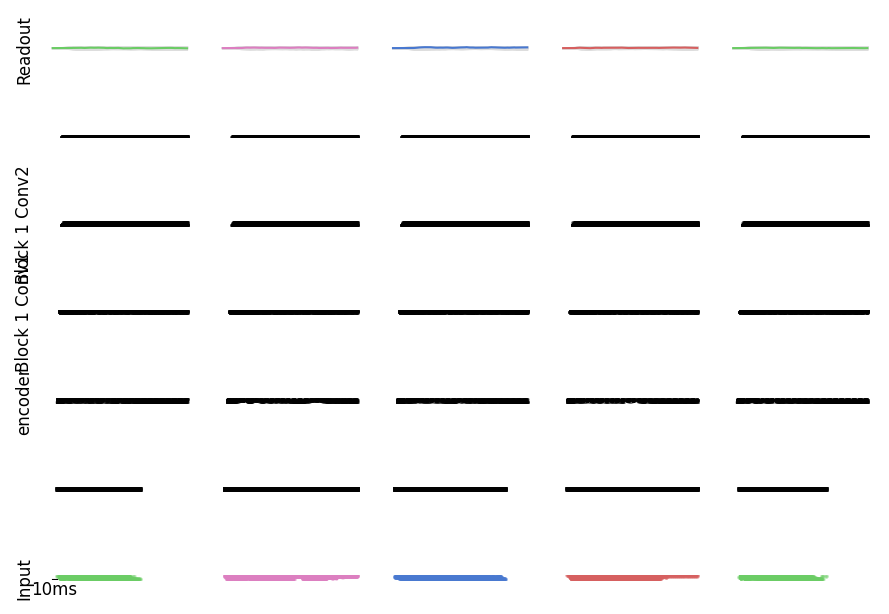

In [ ]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=test_dataset,
    nb_samples=5,
    point_alpha=0.3)

# Training

In [ ]:
results = {}

history = model.fit_validate(
    train_dataset,
    valid_dataset,
    nb_epochs=nb_epochs,
    verbose=True)

results["train_loss"] = history["loss"].tolist()
results["train_acc"] = history["acc"].tolist()
results["valid_loss"] = history["val_loss"].tolist()
results["valid_acc"] = history["val_acc"].tolist()

00  loss=35.7 reg_loss=3.47e-05 acc=0.0695 -- val_loss=10.5 val_reg_loss=3.82e-05 val_acc=0.1 t_iter=28.57
01  loss=7.8 reg_loss=3.8e-05 acc=0.163 -- val_loss=6.39 val_reg_loss=3.54e-05 val_acc=0.245 t_iter=28.26
02  loss=5.45 reg_loss=3.32e-05 acc=0.247 -- val_loss=4.25 val_reg_loss=3.16e-05 val_acc=0.285 t_iter=28.68
03  loss=3.57 reg_loss=3.09e-05 acc=0.358 -- val_loss=2.83 val_reg_loss=2.95e-05 val_acc=0.434 t_iter=28.20
04  loss=2.29 reg_loss=3.11e-05 acc=0.482 -- val_loss=2.21 val_reg_loss=3e-05 val_acc=0.515 t_iter=28.52
05  loss=1.47 reg_loss=3.12e-05 acc=0.613 -- val_loss=1.13 val_reg_loss=2.88e-05 val_acc=0.669 t_iter=28.56
06  loss=1.07 reg_loss=2.78e-05 acc=0.7 -- val_loss=0.892 val_reg_loss=2.51e-05 val_acc=0.727 t_iter=28.35
07  loss=0.763 reg_loss=2.42e-05 acc=0.783 -- val_loss=0.892 val_reg_loss=2.4e-05 val_acc=0.783 t_iter=28.40
08  loss=0.646 reg_loss=2.35e-05 acc=0.816 -- val_loss=0.557 val_reg_loss=2.33e-05 val_acc=0.834 t_iter=28.50
09  loss=0.528 reg_loss=2.25e-05

# Test

In [ ]:
scores = model.evaluate(test_dataset).tolist()
results["test_loss"], _, results["test_acc"] = scores

### Plotting

Test loss:  0.960944880609927
Test acc.:  0.8215217391304348

Validation loss:  0.2952420694960488
Validation acc.:  0.9077777777777776


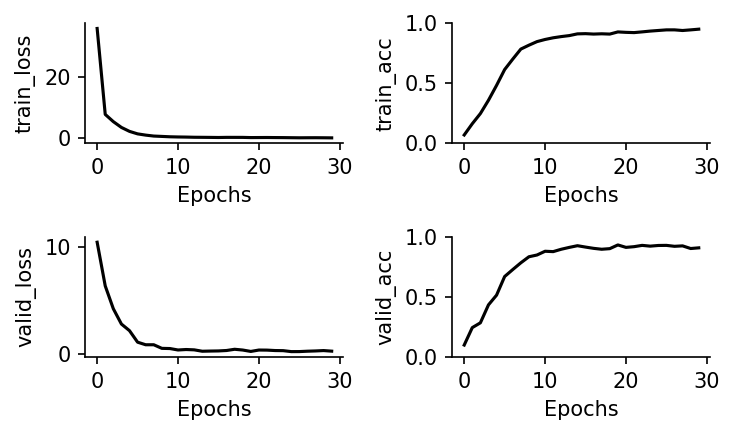

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(5,3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):
    
    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i-2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", results["test_acc"])

print("\nValidation loss: ", results["valid_loss"][-1])
print("Validation acc.: ", results["valid_acc"][-1])

### Snapshot after training

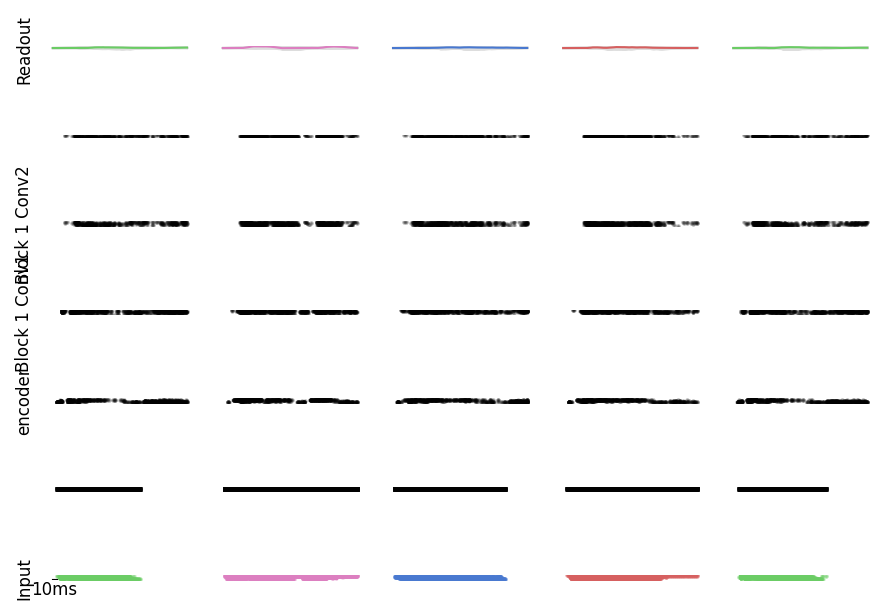

In [ ]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=test_dataset,
    nb_samples=5,
    point_alpha=0.3)